# Getting started with `geovar`

This notebook highlights an instructive example of how to generate "GeoVar"-style plots using an example dataset of 5000 randomly chosen bi-allelic variants on Chromosome 22 from the new high-coverage sequencing of the [1000 Genomes Project from the New York Genome Center](http://ftp.1000genomes.ebi.ac.uk/vol1/ftp/data_collections/1000G_2504_high_coverage/working/20190425_NYGC_GATK/)



## Imports

In [1]:
import numpy as np 
import pandas as pd
import pkg_resources

from geovar.utils import vcf_to_freq_table
from geovar.geovar import GeoVar
from geovar.viz import GeoVarPlot

#visualization tools
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.sans-serif"] = "Arial"

## Data

We have packaged both frequency tables as well as a gzipped vcf dataset within the `geovar` pacakge to illustrate how to move from a [VCF](https://samtools.github.io/hts-specs/VCFv4.2.pdf) file and a population specification file to a full `geovar`-style stacked barplot. 


In [5]:
data_path = pkg_resources.resource_filename("geovar", "data/")

# Filepath to the VCF File
vcf_file = "{}/new_1kg_nygc.chr22.biallelic_snps.filt.n5000.vcf.gz".format(data_path)

# Filepath to the population panel file
population_panel = "{}/integrated_call_samples_v3.20130502.1kg_superpops.panel".format(data_path)

While we may know what the specifications for the VCF format are, the format of the population panel (or cluster file) is defined as a two column file with the columns labeled `sample` and `pop` that are separated by whitespace. 

In [9]:
%%bash -s "$population_panel"

head -n5 $1 

sample pop
HG00096 EUR
HG00097 EUR
HG00099 EUR
HG00100 EUR


In [15]:
# Writing out VCF to a Frequency Table
af_df = vcf_to_freq_table(vcf_file, pop_panel=population_panel, outfile="{}/test.freq.csv".format(data_path), minor_allele=True)
# Print the beginning of the allele frequency table 
af_df.head()

,CHR,SNP,A1,A2,MAC,MAF,AFR,AMR,EAS,EUR,SAS
0,22,10662593,C,T,1,0.000201,0.000759,0.000000,0.000000,0.000000,0.000000
1,22,10664208,G,A,38,0.008137,0.028963,0.000000,0.000000,0.000000,0.000000
2,22,10666881,C,A,1,0.000218,0.000000,0.000000,0.000000,0.000000,0.001104
3,22,10670699,T,A,1633,0.354538,0.228395,0.379538,0.501029,0.259709,0.447137
4,22,10679257,A,T,35,0.007008,0.025797,0.001449,0.000000,0.000000,0.000000


## Generating a GeoVar Object 

Here we now are aiming to actually calculate the binned allele frequency categories (or geovar codes) for each variant across each population. The default binning scheme is to have a binning with (0,0.05], [0.05,0.5]. In theory one could have as many categories as one needs in order to 

In [16]:
# Creating the GeoVar Object 
geovar_test = GeoVar(freq_mat_file="{}/test.freq.csv".format(data_path))

# Generate a geovar binning with the binning we used in our paper
geovar_test.gen_geodist_binning()

# Printing details about the GeoVar object 
print(geovar_test)

GeoVar
number of variants: 5000
number of pops: 5
pops: AFR,AMR,EAS,EUR,SAS
allele freq bins: (0, 0),(0, 0.05),(0.05, 1.0)


## Visualization

Here we will finally generate a "GeoVar" - style plot using the pre-packaged example data

In [22]:
geovar_plot = GeoVarPlot()

# Adding data directly from the geovar object itself
geovar_plot._add_data_geovar(geovar_test)

# Filter to remove very rare categories (only to speed up plotting)
geovar_plot._filter_data()

# Adding in a 
geovar_plot._add_cmap()

Text(0, 0.5, 'Fraction of Variants')

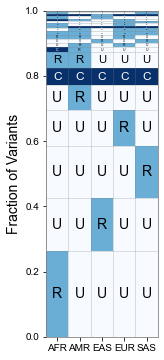

In [25]:
fig, ax = plt.subplots(1,1,figsize=(2,6))
geovar_plot.plot_geodist(ax);

ax.set_xticklabels(geovar_plot.poplist)
ax.set_ylabel('Fraction of variants', fontsize=14)

If we want the percentages next to each value, we can simply run the following:

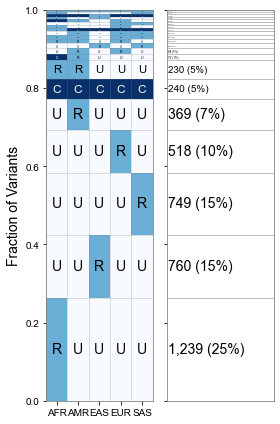

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(4,6), sharey=True)
geovar_plot.plot_geodist(ax[0]);
ax[0].set_xticklabels(geovar_plot.poplist)
ax[0].set_ylabel('Fraction of variants', fontsize=14)

geovar_plot.plot_percentages(ax[1]);
# zero out the xticks
ax[1].set_xticks([])

plt.tight_layout()

## Changing the Binning  

Suppose that we want to distinguish between "low-frequency" ( 1% < MAF < 5%) and "rare" variants (MAF < 1%). We can similarly do this by generating a new binning scheme for the geovar object and then rerunning our plotting code. 

In [30]:
# Setting new bins
geovar_test.generate_bins([0., 0.01, 0.05])

# Generating new geovar codes
geovar_test.gen_geodist_binning()

In [32]:
geovar_plot2 = GeoVarPlot()

# Adding data directly from the geovar object itself
geovar_plot2._add_data_geovar(geovar_test)

# Filter to remove very rare categories (only to speed up plotting)
geovar_plot2._filter_data()

# Adding in a colormap and a new set of labels since we have an additional category
geovar_plot2._add_cmap(str_labels=['U','R','L','C'], lbl_colors=['black', 'black','white','white'])

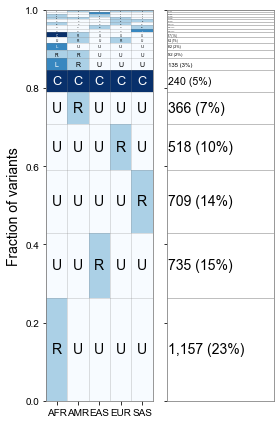

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(4,6), sharey=True)
geovar_plot2.plot_geodist(ax[0]);
ax[0].set_xticklabels(geovar_plot.poplist)
ax[0].set_ylabel('Fraction of variants', fontsize=14)

geovar_plot2.plot_percentages(ax[1]);
# zero out the xticks
ax[1].set_xticks([])

plt.tight_layout()

As you can see the "L" category does not appear till the 7th category here, but it does allow for other ways to break down the frequency categories and further exploration. 

## Reading in from GeoVar Counts Files

For some datasets like the ~92 million variants in the 1000 Genomes Project, it may be that the full frequency table is simply too much to read in and may overload the memory within a given jupyter notebook instance. 


TODO : fill this section out as its important for very large datasets